In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.signal import find_peaks
from sklearn.metrics import mutual_info_score
from matplotlib.pyplot import figure
import matplotlib
from funcs import getStatsMetrics, getHistSignalPlot, getSpikesPlot

matplotlib.rc('figure', figsize=(18, 4))

# Carga de Datos del archivo Control 

In [25]:
data = pd.read_csv('TrozoC.txt', delimiter='\t', header=None, skiprows = range(3), decimal = ",", index_col = False)

In [26]:
print(len(data))
data.drop(columns=[2], inplace=True)
data.columns = ['LP','VD']
data = data.apply(pd.to_numeric)
data['Time'] = data.index
print(data.head())

19847700
         LP        VD  Time
0  0.004883  0.015259     0
1  0.001526  0.024109     1
2 -0.010681  0.031128     2
3 -0.022278  0.041809     3
4 -0.028076  0.045471     4


In [27]:
data.dropna(axis=0, how='any',inplace=True)
data.isnull().sum()

LP      0
VD      0
Time    0
dtype: int64

In [28]:
data.describe()

,LP,VD,Time
count,1.984770e+07,1.984770e+07,1.984770e+07
mean,-2.253853e-08,4.385849e-02,9.923850e+06
std,8.214042e-02,3.287948e-02,5.729538e+06
min,-7.101440e-01,-2.170715e+00,0.000000e+00
25%,-2.288800e-02,3.295900e-02,4.961925e+06
50%,3.050000e-04,4.364000e-02,9.923850e+06
75%,2.410900e-02,5.401600e-02,1.488577e+07
max,9.344480e-01,1.351624e+00,1.984770e+07


# Cálculo del umbral

In [29]:
dist_sd=4

lp_mean,lp_sd,low_lp,high_lp = getStatsMetrics(data.LP, dist_sd)
print('LP:\n\tMean: %f\n\tSD: %f\n\tLow: %f\n\tHigh: %f'%(lp_mean,lp_sd,low_lp,high_lp))

vd_mean,vd_sd,low_vd,high_vd = getStatsMetrics(data.VD, dist_sd)
print('VD:\n\tMean: %f\n\tSD: %f\n\tLow: %f\n\tHigh: %f'%(vd_mean,vd_sd,low_vd,high_vd))

LP:
	Mean: -0.000000
	SD: 0.082140
	Low: -0.328562
	High: 0.328562
VD:
	Mean: 0.043858
	SD: 0.032879
	Low: -0.087659
	High: 0.175376


# Visualización del histograma de la señal y el umbral escogido

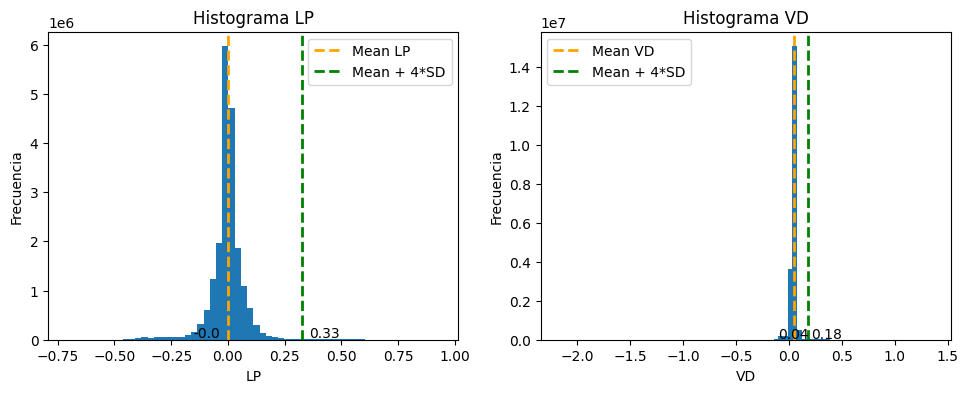

In [30]:
plt.subplot(1,3,1)
getHistSignalPlot(data.LP,lp_mean,low_lp,high_lp, dist_sd, 'LP', bins=60)

plt.subplot(1,3,2)
getHistSignalPlot(data.VD,vd_mean,low_vd,high_vd, dist_sd, 'VD', bins=80)

# Codificación de spikes

In [31]:
spikes_lp = find_peaks(data['LP'])[0]
spikes_vd = find_peaks(data['VD'])[0]

lp_sp_data = pd.DataFrame(data = {'Time':spikes_lp,'ValueLP':data['LP'][spikes_lp],'IsSpikeLP' : 1})
lp_sp_data = lp_sp_data[lp_sp_data['ValueLP'] >= high_lp]

vd_sp_data = pd.DataFrame(data = {'Time':spikes_vd,'ValueVD':data['VD'][spikes_vd],'IsSpikeVD' : 1})
vd_sp_data = vd_sp_data[vd_sp_data['ValueVD'] >= high_vd]


In [32]:
data = pd.merge(data, lp_sp_data, on = 'Time', how='left')
data = pd.merge(data, vd_sp_data, on = 'Time', how='left')
data['IsSpikeLP'].fillna(0, inplace=True)
data['IsSpikeVD'].fillna(0, inplace=True)


In [33]:
data.head()

,LP,VD,Time,ValueLP,IsSpikeLP,ValueVD,IsSpikeVD
0,0.004883,0.015259,0,NaN,0.0,NaN,0.0
1,0.001526,0.024109,1,NaN,0.0,NaN,0.0
2,-0.010681,0.031128,2,NaN,0.0,NaN,0.0
3,-0.022278,0.041809,3,NaN,0.0,NaN,0.0
4,-0.028076,0.045471,4,NaN,0.0,NaN,0.0


# Visualización de los spikes en la señal

C:\Users\marlo\AppData\Local\Temp\ipykernel_10792\1222925315.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2.loc[:,'breaks'] = np.repeat(breaks,break_size)[0:data_end-data_init]
C:\Users\marlo\AppData\Local\Temp\ipykernel_10792\1222925315.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2.loc[:,'breaks'] = np.repeat(breaks,break_size)[0:data_end-data_init]


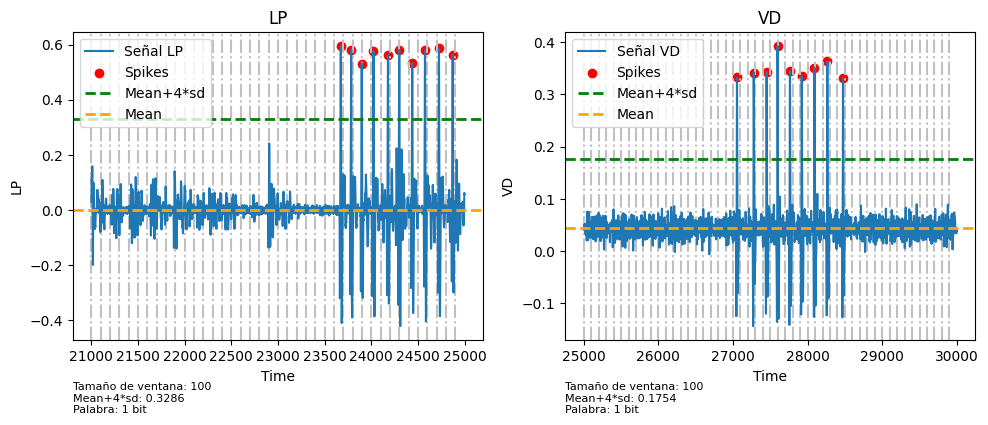

In [34]:
plt.subplot(1,3,1)
getSpikesPlot(data, 100, 21000, 25000,high_lp,lp_mean, 'LP')

plt.subplot(1,3,2)
getSpikesPlot(data, 100, 25000, 30000,high_vd, vd_mean, 'VD')

# Agrupación por tamaño de palabra o bit

In [35]:
for p in range(1,9):
    palabra = p
    breaks = np.arange(0,len(data),palabra)
    data.loc[:,'W'+str(p)] = np.repeat(breaks,palabra)[0:len(data)]

data.head()

,LP,VD,Time,ValueLP,IsSpikeLP,ValueVD,IsSpikeVD,W1,W2,W3,W4,W5,W6,W7,W8
0,0.004883,0.015259,0,NaN,0.0,NaN,0.0,0,0,0,0,0,0,0,0
1,0.001526,0.024109,1,NaN,0.0,NaN,0.0,1,0,0,0,0,0,0,0
2,-0.010681,0.031128,2,NaN,0.0,NaN,0.0,2,2,0,0,0,0,0,0
3,-0.022278,0.041809,3,NaN,0.0,NaN,0.0,3,2,3,0,0,0,0,0
4,-0.028076,0.045471,4,NaN,0.0,NaN,0.0,4,4,3,4,0,0,0,0


In [36]:
data_palabras = list()

for i in data.columns[7:len(data.columns)]:
    d = data.groupby(i)[['IsSpikeLP','IsSpikeVD']].agg('sum').reset_index()
    d['IsSpikeLP'] = d['IsSpikeLP'] > 0
    d['IsSpikeVD'] = d['IsSpikeVD'] > 0
    data_palabras.append(d)

    print('Tamaño de Palabra: %s\nDimensión dataframe: %s'%(str(i),str(d.shape)))
    print(d.head(3))
    print('\n')

Tamaño de Palabra: W1
Dimensión dataframe: (19847700, 3)
   W1  IsSpikeLP  IsSpikeVD
0   0      False      False
1   1      False      False
2   2      False      False


Tamaño de Palabra: W2
Dimensión dataframe: (9923850, 3)
   W2  IsSpikeLP  IsSpikeVD
0   0      False      False
1   2      False      False
2   4      False      False


Tamaño de Palabra: W3
Dimensión dataframe: (6615900, 3)
   W3  IsSpikeLP  IsSpikeVD
0   0      False      False
1   3      False      False
2   6      False      False


Tamaño de Palabra: W4
Dimensión dataframe: (4961925, 3)
   W4  IsSpikeLP  IsSpikeVD
0   0      False      False
1   4      False      False
2   8      False      False


Tamaño de Palabra: W5
Dimensión dataframe: (3969540, 3)
   W5  IsSpikeLP  IsSpikeVD
0   0      False      False
1   5      False      False
2  10      False      False


Tamaño de Palabra: W6
Dimensión dataframe: (3307950, 3)
   W6  IsSpikeLP  IsSpikeVD
0   0      False      False
1   6      False      False
2  12    

# Cálculo de Entropía, MI y Error para distintos tamaños de ventana y palabra

In [37]:
window_sizes_w = np.arange(5,600,10)
df_w_metrics = {}

for df_w in data_palabras:
    df_w_MI = []
    df_w_MI_norm = []
    df_w_E_lp = []
    df_w_E_vd = []
    df_entropy_lp_a_vd = []
    df_entropy_vd_a_lp = []

    for win_size in window_sizes_w:
        breaks = np.arange(0,len(df_w),win_size)
        d = df_w
        d.loc[:,'breaks'] = np.repeat(breaks,win_size)[0:len(d)]
        d = d.groupby('breaks')[['IsSpikeLP','IsSpikeVD']].agg('sum').reset_index()
        d['ErrorsLP'] = d['IsSpikeLP'] > 1
        d['ErrorsVD'] = d['IsSpikeVD'] > 1
        df_w_E_lp.append(sum(d['ErrorsLP'])/len(d)*100)
        df_w_E_vd.append(sum(d['ErrorsVD'])/len(d)*100)

        MI = mutual_info_score(d['IsSpikeLP'], d['IsSpikeVD'])
        MI_norm = mutual_info_score(d['IsSpikeLP'], d['IsSpikeVD'])/(win_size*int(df_w.columns[0][1]))
        Slp = stats.entropy(d['IsSpikeLP'])
        Svd = stats.entropy(d['IsSpikeVD'])

        df_w_MI.append(MI) 
        df_w_MI_norm.append(MI_norm)   
        df_entropy_lp_a_vd.append(MI/Svd)
        df_entropy_vd_a_lp.append(MI/Slp)

    df_w_m = pd.DataFrame({'WindSize':window_sizes_w, 'ErrorLP':df_w_E_lp, 'ErrorVD':df_w_E_vd, 
                           'MI':df_w_MI, 'MI_norm':df_w_MI_norm, 'Slp_vd':df_entropy_lp_a_vd,'Svd_lp':df_entropy_vd_a_lp})
    df_w_metrics[df_w.columns[0]]  = df_w_m




In [38]:
df_w_metrics['W1'].head()

,WindSize,ErrorLP,ErrorVD,MI,MI_norm,Slp_vd,Svd_lp
0,5,0.000000,0.000000,0.000035,0.000007,0.000004,0.000003
1,15,0.000529,0.000227,0.000322,0.000021,0.000032,0.000031
2,25,0.001637,0.000756,0.000904,0.000036,0.000090,0.000087
3,35,0.005467,0.002645,0.001795,0.000051,0.000179,0.000173
4,45,0.010883,0.003628,0.002934,0.000065,0.000293,0.000283


# Visualización del Error

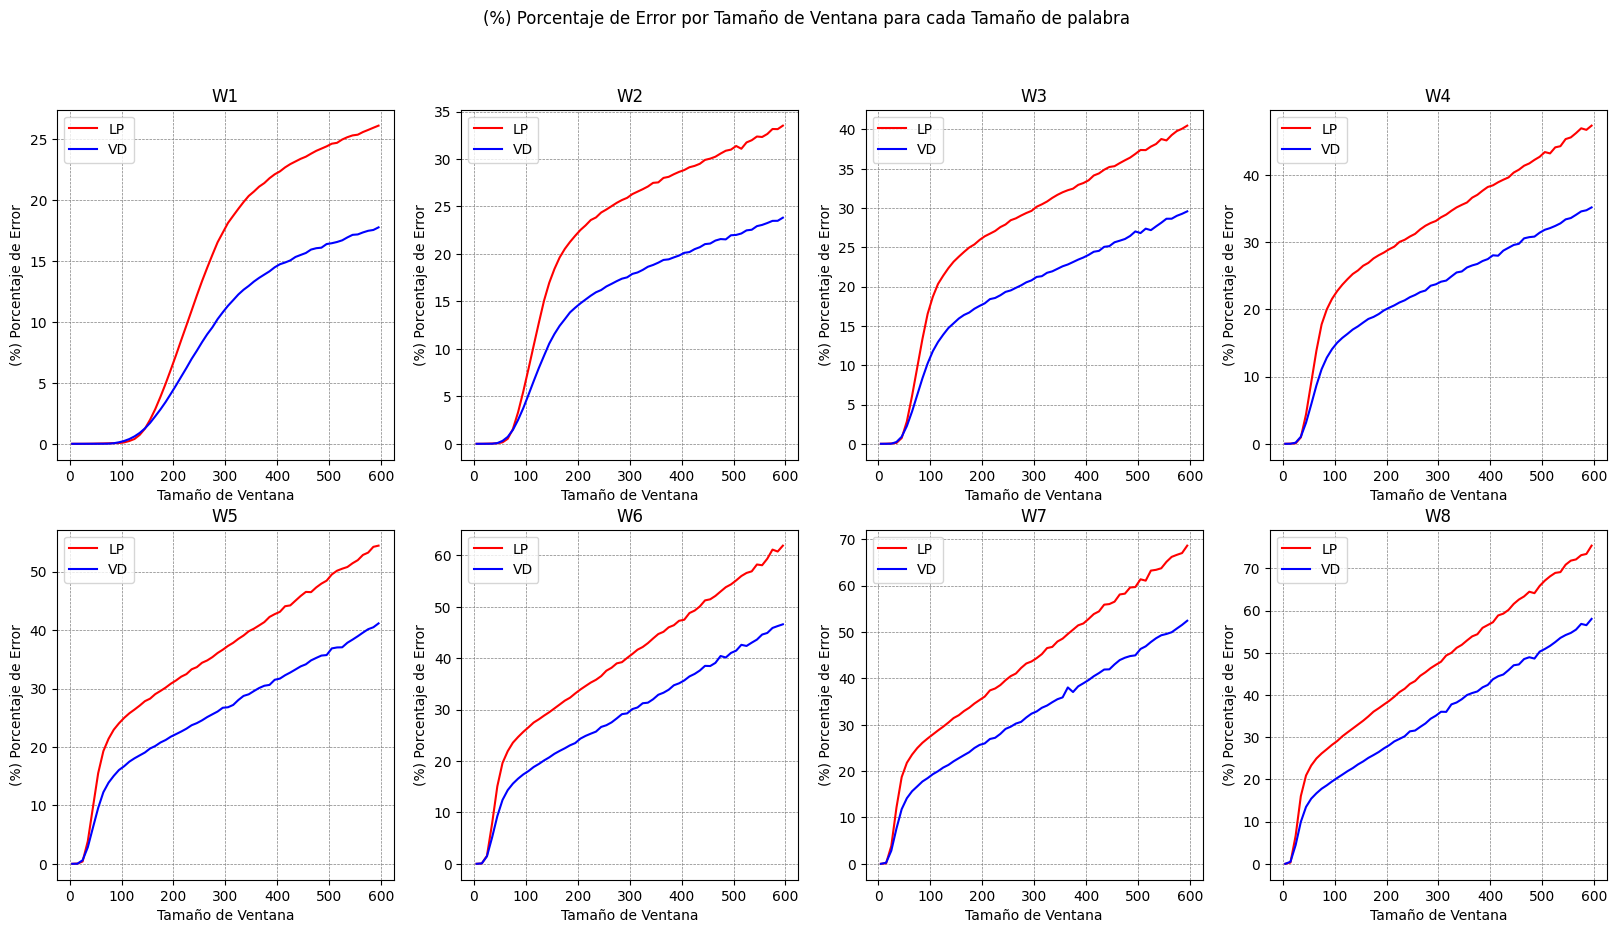

In [39]:
n_rows = 2
n_cols = 4
keys = [key for key in df_w_metrics]

fig, axs = plt.subplots(n_rows, n_cols)
n_plots = 0
fig.suptitle('(%) Porcentaje de Error por Tamaño de Ventana para cada Tamaño de palabra')
for r in range(n_rows):
    for c in range(n_cols):
        df = df_w_metrics[keys[n_plots]]

        axs[r, c].plot(df['WindSize'], df['ErrorLP'],color = 'red', label = 'LP')
        axs[r, c].plot(df['WindSize'], df['ErrorVD'],color = 'blue', label = 'VD')
        axs[r, c].set_title(keys[n_plots])
        axs[r, c].grid(color = 'gray', linestyle = '--', linewidth = 0.5)
        axs[r, c].legend()


        n_plots+=1

for ax in axs.flat:
    ax.set(xlabel='Tamaño de Ventana', ylabel='(%) Porcentaje de Error')

fig.set_size_inches(20, 10)


# Visualización de la Información Mutua Normalizada por Tamaño de Ventana y Palabra

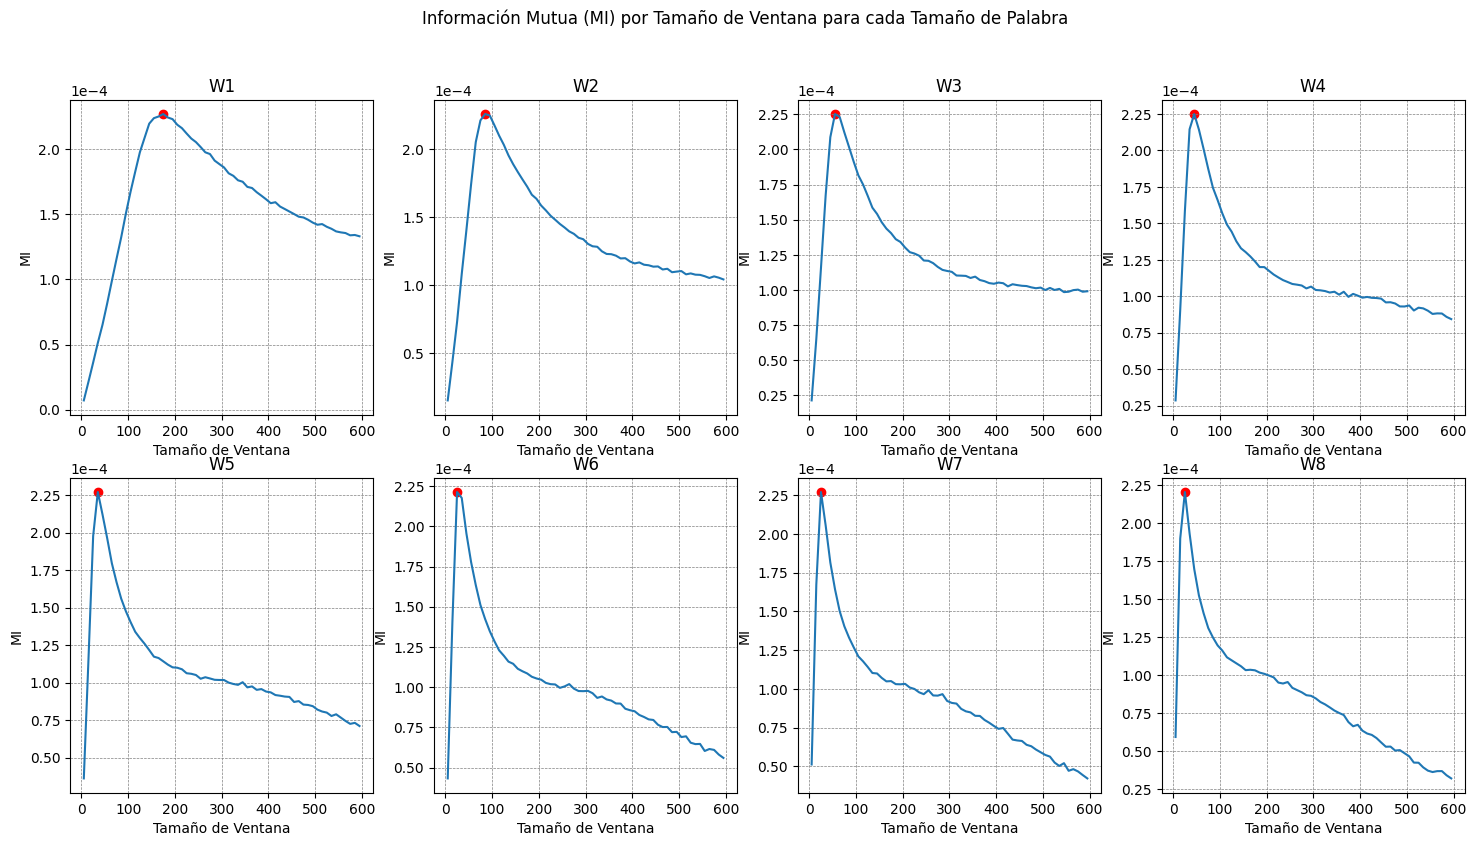

In [40]:
n_cols = 4
keys = [key for key in df_w_metrics]

best_wind = []
best_MI = []

fig, axs = plt.subplots(n_rows, n_cols)
n_plots = 0
fig.suptitle('Información Mutua (MI) por Tamaño de Ventana para cada Tamaño de Palabra')
for r in range(n_rows):
    for c in range(n_cols):
        df = df_w_metrics[keys[n_plots]]

        max_val = list(df['MI_norm']).index(max(df['MI_norm']))
        x_max_val = df['WindSize'][max_val]
        y_max_val = df['MI_norm'][max_val]

        axs[r, c].plot(df['WindSize'], df['MI_norm'])
        axs[r, c].scatter(x_max_val, y_max_val, c = 'r')
        axs[r, c].set_title(keys[n_plots])
        axs[r, c].grid(color = 'gray', linestyle = '--', linewidth = 0.5)
        axs[r, c].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

        best_wind.append(df['WindSize'][max_val])
        best_MI.append(y_max_val)


        n_plots+=1

for ax in axs.flat:
    ax.set(xlabel='Tamaño de Ventana', ylabel='MI')

# for ax in axs.flat:
#     ax.label_outer()

fig.set_size_inches(18, 9)

In [41]:
# df_wind_inf = pd.DataFrame({'bits':np.arange(1,9),'WindSize':best_wind, 'best_MI':best_MI})
# df_wind_inf.sort_values(by='best_MI', ascending=False, inplace=True)
# print(df_wind_inf.to_latex(index=False,formatters={"name": str.upper}))

# Visualización Trasferencia de Entropía

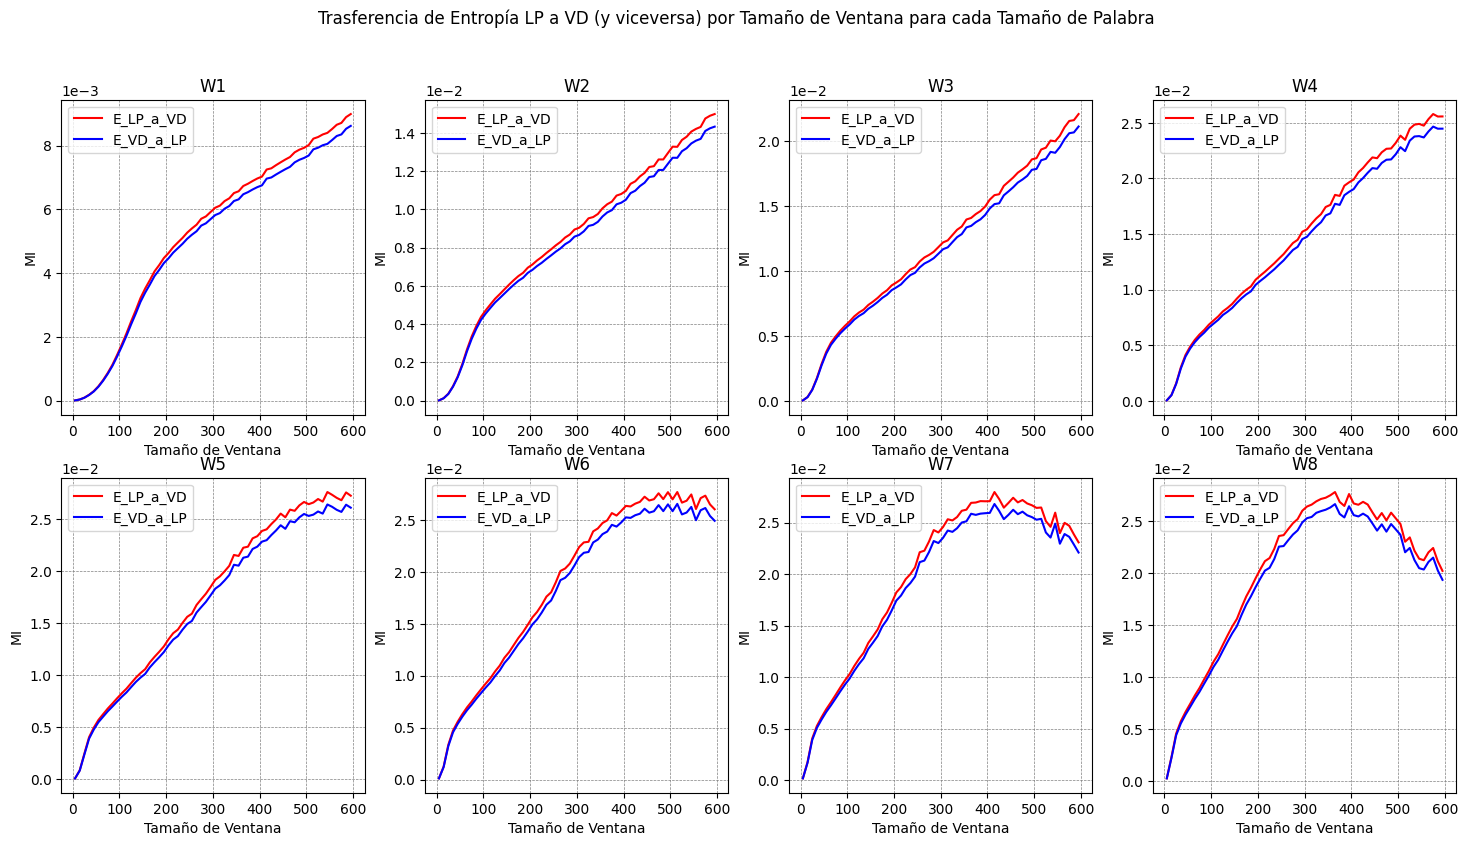

In [42]:
n_cols = 4
keys = [key for key in df_w_metrics]

fig, axs = plt.subplots(n_rows, n_cols)
n_plots = 0
fig.suptitle('Trasferencia de Entropía LP a VD (y viceversa) por Tamaño de Ventana para cada Tamaño de Palabra')
for r in range(n_rows):
    for c in range(n_cols):
        df = df_w_metrics[keys[n_plots]]

        axs[r, c].plot(df['WindSize'], df['Slp_vd'],color = 'red', label = 'E_LP_a_VD')
        axs[r, c].plot(df['WindSize'], df['Svd_lp'],color = 'blue', label = 'E_VD_a_LP')
        axs[r, c].set_title(keys[n_plots])
        axs[r, c].grid(color = 'gray', linestyle = '--', linewidth = 0.5)
        axs[r, c].legend()
        axs[r, c].ticklabel_format(style='sci', axis='y', scilimits=(0,0))


        n_plots+=1

for ax in axs.flat:
    ax.set(xlabel='Tamaño de Ventana', ylabel='MI')

# for ax in axs.flat:
#     ax.label_outer()

fig.set_size_inches(18, 9)